# Imports and Initialization of Config Class/File

In [120]:
from io import open
import unicodedata
import string
import re
import random
import numpy as np
from tqdm import tqdm_notebook as tqdm
# from distance import levenshtein -> Not necessary as implemented from scratch
import os
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils import data
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
#from torchtext.data import BucketIterator

seed = '4'
if seed is not None:
    random.seed(seed)

In [121]:
#cfg class which is easliy translatible into a cfg file

class Config:
    seed = '5'
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dict_name = 'rcrl_apd.1.4.1.txt'
    epochs = 200
    batch_size = 128
    hidden_dim = 256
    embed_dim = 256
    dropout = 0.1
    dec_max_len = 30
    MAX_LENGTH = 20
    p_tf = 0.5
    n_layers = 2
    lr = 0.001

cfg = Config()

In [122]:
print(cfg.device)

cuda


# Preparation of Datasets(using torchtext)

In [123]:
def dict_sorting (dict_file_name):
    dict_file = open(dict_file_name, 'r')
    lines_dict = dict_file.readlines()
    dict_file.close()

    graphemes = []
    phonemes = []

    for i in range(0, len(lines_dict)):
        lines_dict[i] = lines_dict[i].split()
        graphemes.append([*lines_dict[i][0]])
        phonemes.append(lines_dict[i][1:])
    phonemes = [a for b in phonemes for a in b]
    graphemes = [a for b in graphemes for a in b]
    graphemes = sorted(set(graphemes))
    phonemes = sorted(set(phonemes))
    return graphemes, phonemes

dict_file_name = cfg.dict_name
g_seq, p_seq = dict_sorting(dict_file_name)
cfg.graphemes = ["<pad>", "</s>"] + g_seq
cfg.phonemes = ["<pad>", "<s>", "</s>"] + p_seq

#Index to grapheme and phones for vectors
cfg.graph2index = {g: idx for idx, g in enumerate(cfg.graphemes)}
cfg.index2graph = {idx: g for idx, g in enumerate(cfg.graphemes)}

cfg.phone2index = {p: idx for idx, p in enumerate(cfg.phonemes)}
cfg.index2phone = {idx: p for idx, p in enumerate(cfg.phonemes)}

print(cfg.graphemes)
print(cfg.phonemes)
cfg.g_vocab_size = len(cfg.graphemes)
cfg.p_vocab_size = len(cfg.phonemes)
print(cfg.phone2index)
print(cfg.graph2index)

['<pad>', '</s>', "'", 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'á', 'ä', 'è', 'é', 'ê', 'ë', 'í', 'ï', 'ó', 'ô', 'ö', 'ú', 'û']
['<pad>', '<s>', '</s>', '2:', '9', '9y', '@', '@i', '@u', 'A:', 'E', 'N', 'O', 'Of', 'S', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h_', 'i', 'i@', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'u', 'u@', 'v', 'w', 'x', 'y', 'z', '{']
{'<pad>': 0, '<s>': 1, '</s>': 2, '2:': 3, '9': 4, '9y': 5, '@': 6, '@i': 7, '@u': 8, 'A:': 9, 'E': 10, 'N': 11, 'O': 12, 'Of': 13, 'S': 14, 'Z': 15, 'a': 16, 'b': 17, 'd': 18, 'e': 19, 'f': 20, 'g': 21, 'h_': 22, 'i': 23, 'i@': 24, 'j': 25, 'k': 26, 'l': 27, 'm': 28, 'n': 29, 'p': 30, 'r': 31, 's': 32, 't': 33, 'u': 34, 'u@': 35, 'v': 36, 'w': 37, 'x': 38, 'y': 39, 'z': 40, '{': 41}
{'<pad>': 0, '</s>': 1, "'": 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 1

In [124]:
def DataLoading(dict_file_name, data_split):
    def sortingWP (d):
        w, p = [], []
        for i in range(0, len(d)):
            #w.append(d[i][0])
            w.append(' '.join(d[i][0]))
            p.append((' '.join(d[i][1:])))
        return w,p

    with open(dict_file_name) as f:
        dict_lines = f.readlines()
    vocab_len = len(dict_lines)
    print(vocab_len)
    random.shuffle(dict_lines)

    #Potential to add 'n to train dataset
    
    for i in range(0, len(dict_lines)):
        dict_lines[i] = dict_lines[i].split()
    train_data_lines, test_data_lines, eval_data_lines = [], [], []
    train_data_lines = dict_lines[0:int(data_split[0]*vocab_len)]
    test_data_lines = dict_lines[int(data_split[0]*vocab_len):int((data_split[0]+data_split[1])*vocab_len)]
    eval_data_lines = dict_lines[int((data_split[0]+data_split[1])*vocab_len):]

    train_word, train_phonemes = sortingWP(train_data_lines)
    test_word, test_phonemes = sortingWP(test_data_lines)
    eval_word, eval_phonemes = sortingWP(eval_data_lines)
    
    return train_word, train_phonemes, test_word, test_phonemes, eval_word, eval_phonemes

In [125]:
# def DataLoading(dict_file_name, data_split):
#     def sortingWP (d):
#         w, p = [], []
#         for i in range(0, len(d)):
#             #w.append(d[i][0])
#             w.append(' '.join(d[i][0]))
#             p.append((' '.join(d[i][1:])))
#         return w,p

#     with open(dict_file_name) as f:
#         dict_lines = f.readlines()
#     vocab_len = len(dict_lines)
#     print(vocab_len)
#     random.shuffle(dict_lines)

#     #Potential to add 'n to train dataset
    
#     for i in range(0, len(dict_lines)):
#         dict_lines[i] = dict_lines[i].split()
#     train_data_lines, test_data_lines, eval_data_lines = [], [], []
#     train_data_lines = dict_lines
#     eval_data_lines = dict_lines[0:int(data_split[1]*vocab_len)]
#     #test_data_lines = dict_lines[int(data_split[0]*vocab_len):int((data_split[0]+data_split[1])*vocab_len)]

#     train_word, train_phonemes = sortingWP(train_data_lines)
#     #test_word, test_phonemes = sortingWP(test_data_lines)
#     eval_word, eval_phonemes = sortingWP(eval_data_lines)
    
#     return train_word, train_phonemes, eval_word, eval_phonemes

In [126]:
# split = [0.8, 0.1, 0.1]
# train_word, train_phonemes = DataLoading(cfg.dict_name, split)

# #Sanity Check
# print(len(train_word))
# print(len(train_phonemes))
# print(train_word[0])
# print(train_phonemes[0])

In [127]:
split = [0.8, 0.1, 0.1]
train_word, train_phonemes, test_word, test_phonemes, eval_word, eval_phonemes = DataLoading(cfg.dict_name, split)
#train_word, train_phonemes, eval_word, eval_phonemes = DataLoading(cfg.dict_name, split)
#Sanity Check
print(len(train_phonemes))
print(len(eval_phonemes))

24175
19340
2418


# Data Encoder & Decoder
converts data to their dictionary equivalents based on indices(And decoder which will be used when finally checking sequences)

In [128]:
def data_encoder(seq, isWord):
    # Automatically encoders sequence with graph2index if words
    tokenized_seq = []
    if isWord: 
        seq = [*seq] + ['</s>']
        seq = [i for i in seq if i!=" "]
        for i in seq:
            a = cfg.graph2index[i]
            tokenized_seq.append(a)
    #Else simply add end of sequence token to to phoneme sequences
    else:
        a = '<s> ' + str(seq) +' </s>'
        seq = a.split(" ")
        ans = ""
        for i in seq:
            if i== 'o': i="O"
            elif i== 'h': i="h_"
            a = cfg.phone2index[i]
            tokenized_seq.append(a)

    #Tokenize sequence
    return tokenized_seq

In [129]:
print(train_word[0])
print(train_phonemes[0])
a = data_encoder(train_word[0], 1)
b = data_encoder(train_phonemes[0], 0)
print(a)
print(b)

o n t s n a p p i n g
O n t s n a p @ N
[17, 16, 22, 21, 16, 3, 18, 18, 11, 16, 9, 1]
[1, 12, 29, 33, 32, 29, 16, 30, 6, 11, 2]


In [130]:
def data_decoder(sequence, isWord):
    """Converts index sequence back into corresponding letter tokens"""
    if isWord: tokenizer = cfg.index2graph
    else: tokenizer = cfg.index2phone
    converted_sequence = []
    
    for i in sequence:
        if tokenizer[i] == "</s>": break
        a = tokenizer[i]
        converted_sequence.append(a)
    return converted_sequence

In [131]:
a = [14, 4, 19, 23, 8, 12, 17, 2]
b = [27, 17, 31, 34, 8, 30, 3]
a = data_decoder(a, 1)
b = data_decoder(b, 0)
print(a)
print(b)

['l', 'b', 'q', 'u', 'f', 'j', 'o', "'"]
['l', 'b', 'r', 'u', '@u', 'p', '2:']


# Dataset Class 
(Adapted from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

In [132]:
class G2PData (data.Dataset):
    def __init__(self, graphemes, phonemes):
        self.graphemes = graphemes
        self.phonemes = phonemes

    def __len__(self):
        return len(self.graphemes)

    def __getitem__(self, index):
        graphemes = self.graphemes[index]
        phonemes = self.phonemes[index]

        #Fetches encoded versions
        grapheme_vector = data_encoder(graphemes, 1)
        phoneme_vector = data_encoder(phonemes, 0)

        #Omits </s> character
        decoder_inputs = phoneme_vector[:-1]
        phoneme_vector = phoneme_vector[1:]

        #Used for padding purposes
        g_vec_len = len(grapheme_vector) 
        p_vec_len = len(phoneme_vector)
        
        return grapheme_vector, phoneme_vector, decoder_inputs, g_vec_len, p_vec_len


In [133]:
trainDataset = G2PData(train_word, train_phonemes)
#testDataset = G2PData(test_word, test_phonemes)
evalDataset = G2PData(eval_word, eval_phonemes)

Padding: To ensure datasets in the same batch are of the same length (Could also use bucketiterator to choose strings)

# Model Setup
Based on seq2seq tutorial for Machine Translation (https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)

Potential implementation of Attention: https://www.kaggle.com/code/omershect/learning-pytorch-seq2seq-with-m5-data-set/notebook

In [134]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, g_vocab_size, n_layers, dropout):
        super().__init__()
        self.embed = embed_dim
        self.hidden = hidden_dim
        self.embed = nn.Embedding(g_vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first = True)
    
    def forward(self, graph_seq, graph_seq_len):
        embed_inputs = self.embed(graph_seq)
        inputs = self.dropout(embed_inputs)

        #https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html
        #packs padded sequences into tensor
        input_tensor = pack_padded_sequence(inputs, graph_seq_len, batch_first=True, enforce_sorted=False)
        output, (hidden, context) = self.lstm(input_tensor)

        return hidden, context

In [135]:
class Decoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, p_vocab_size, n_layers, dropout):
        super().__init__()
        self.embed = embed_dim
        self.hidden = hidden_dim
        self.embed = nn.Embedding(p_vocab_size, embed_dim)
        self.dropout = nn.Dropout(dropout) 
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim ,p_vocab_size) #Predicts output
    
    def forward(self, decoder_inputs, hidden_init, context_init):

        
        embed_inputs = self.embed(decoder_inputs)
        inputs = self.dropout(embed_inputs)

        #is already a tensor

        output, (hidden, context) = self.lstm(inputs, (hidden_init, context_init))


        #Transforming (batch_size,max_len,hidden_size) -> (batch_size,1,dictionary_size)

        activation_output = self.fc(output)

        

        
        
        return activation_output, hidden, context

In [136]:
class G2PModel(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.enc = encoder
        self.dec = decoder
        self.device = device
        
    def forward(self, graph_seq, graph_seq_len,phone_seq_len, decoder_inputs, phoneme_target_vec = None, training = False, teacher_forcing = cfg.p_tf):
        
        #Obtain hidden and context vectors from encoder
        hidden_init, context_init = self.enc(graph_seq, graph_seq_len)
        hidden, context = hidden_init, context_init

        max_len = max(phone_seq_len)

        phoneme_input_vec = decoder_inputs[:, :1]
        outputs = [] 
        phone_pred_seq = []
            
        if training:
            for i in range(0, max_len):

                output, hidden, context = self.dec(phoneme_input_vec ,hidden, context)
                outputs.append(output)
                # phone_pred = torch.tensor(output.argmax(-1))

                if random.random() > teacher_forcing: 
                    phoneme_input_vec = phoneme_target_vec[:,i]
                    # print("teacher force")
                    # print(phoneme_input_vec.shape)
                    
                # else:  phoneme_input_vec = decoder_inputs[:,i]
                else: 
                    phoneme_input_vec = torch.squeeze(output.argmax(-1))
                    
                    # print("not teacherforce")
                    # print(phoneme_input_vec.shape)
                    # print(i)
                    # print(phoneme_input_vec)
                phoneme_input_vec = torch.unsqueeze(phoneme_input_vec,1)

        else: #for prediction
            for i in range(1, cfg.dec_max_len+1):
                output, hidden, context = self.dec(phoneme_input_vec ,hidden, context)
                
                phone_pred = output.argmax(-1)
                outputs.append(output)
                phone_pred_seq.append(phone_pred)
                phoneme_input_vec = phone_pred
                #print(i)
                #print(phoneme_input_vec.shape)
            phone_pred_seq = torch.cat(phone_pred_seq, 1)
            
        output = torch.cat(outputs, 1)
        
        return output, phone_pred_seq

# Iterators Initialization and Padding

Padding_data takes a batch and pads it for every iteration

In [137]:
def padding_data(batch):

    #Each sequence has a form:
    # grapheme_vector, phoneme_vector, decoder_inputs, g_vec_len, p_vec_len, graphemes, phonemes

    def get_components(batch, index):
        ans = []
        for i in batch:
            ans.append(i[index])
        return ans
    
    def pad_seq(batch, index, max_len):
        ans = []
        no_zeros_to_add = 0
        for i in batch:
            no_zeros_to_add = max_len - len(i[index])
            ans.append(i[index] + [0] * no_zeros_to_add)
        return torch.LongTensor(ans)
    
    grapheme_lens = [len(g[0]) for g in batch]

    phonemes_lens = [len(p[1]) for p in batch]

    input_maxlen = max(grapheme_lens)
    output_maxlen = max(phonemes_lens)
    padded_inputs = pad_seq(batch, 0, input_maxlen)
    padded_outputs = pad_seq(batch, 1, output_maxlen)
    padded_decoder_inputs = pad_seq(batch, 2, output_maxlen)

    return padded_inputs, padded_outputs, padded_decoder_inputs, grapheme_lens, phonemes_lens

In [138]:
#Data Loader Implementation
#Shuffling not required as already loaded in a shuffled manner

train_iter =  data.DataLoader(trainDataset,batch_size=cfg.batch_size, shuffle=False, collate_fn=padding_data)
#test_iter = data.DataLoader( testDataset,batch_size=cfg.batch_size, shuffle=False, collate_fn=padding_data)
eval_iter = data.DataLoader(evalDataset,batch_size=cfg.batch_size, shuffle=False, collate_fn=padding_data)

# Training and Evaluation Functions

Model, Optimizer and Criterion Initializer

In [139]:
def train(model, iterator, optimizer, criterion, device):
    model.train() #sets model in training model
    
    loss_epoch = 0
    

    for i, batch in enumerate(iterator):
        grapheme_vector, phoneme_vector, decoder_inputs, g_vec_len, p_vec_len = batch

        
        #Placing vectors in GPU to streamline process
        grapheme_vector = grapheme_vector.to(device)
        phoneme_vector = phoneme_vector.to(device)
        decoder_inputs = phoneme_vector.to(device)

        optimizer.zero_grad() #Sets all gradients to zero


        phoneme_pred,_ = model(grapheme_vector, g_vec_len,p_vec_len, decoder_inputs,phoneme_vector, True)

        #phoneme_pred is in shape (batchsize, max_len, p_vocab_size) -> need to drop the last dimension

        phoneme_pred = phoneme_pred.view(-1, phoneme_pred.shape[-1])
        phoneme_vector = phoneme_vector.view(-1)

        loss = criterion(phoneme_pred, phoneme_vector)

        loss.backward()

        optimizer.step()

        #Print loss every 50 batches
        # if (i % 50 == 0) and (i != 0) and i <100 : print(f" {i} batches completed: train loss: {loss}")
        # elif (i % 50 == 0) and (i != 0) : print(f"{i} batches completed: train loss: {loss}")


        #Normalizing Loss per batch
        loss_epoch += loss.item()/len(batch)

    return loss_epoch

In [140]:
def leven(target_word, pred_word):
    lev_matrix = np.zeros((len(target_word)+1, len(pred_word)+1))
    lev_matrix[0,:] = np.arange(0, len(pred_word) + 1)
    lev_matrix[:,0] = np.arange(0, len(target_word) + 1)
    for i in range(1, len(target_word)+1):
        for j in range(1, len(pred_word)+1):
            if target_word[i-1] == pred_word[j-1]:
                lev_matrix[i,j] = lev_matrix[i-1,j-1]
            else:
                lev_matrix[i,j] = np.min([lev_matrix[i-1,j-1], lev_matrix[i,j-1], lev_matrix[i-1,j]]) + 1

    return(lev_matrix[len(lev_matrix)-1,-1])

In [141]:
def Accuracy_PER_calculation(phoneme_vector_text, phoneme_predict_text):
    "Accuracy - Words that are not 100% correct"
    "PER - Rate at which phonemes are incorrectly generated - Levenshtein distance/n_phones in correct text"
    n_wrong_words =   0
    total_phones_real = 0
    n_incorrect_phones = 0

    n_entries = len(phoneme_vector_text)

    for i in range(n_entries):
        total_phones_real += len(phoneme_vector_text[i])
        ans = leven(phoneme_vector_text[i], phoneme_predict_text[i])
        n_incorrect_phones += ans
        if ans !=0 : n_wrong_words +=1
        
    #phoneme_error_rate = incorrect_phones/total_phones_real - incorrect as doesnt allow a sensible way to work out PER over entire epoch
    #accuracy = n_wrong_words/n_entries
    
    return n_incorrect_phones, total_phones_real, n_wrong_words, n_entries 

In [142]:
def evaluate(model, iterator, criterion, device):

    def pad_p_vec(phoneme_vector, max_len):
        phoneme_vector = phoneme_vector.cpu().numpy()
        
        ans = []

        for i in phoneme_vector:
            no_zeros_to_add = (max_len - len(i))
            j = np.array(no_zeros_to_add * [0])
            j = j.reshape((no_zeros_to_add, 1))
            i = i.reshape((len(i), 1))

            ans.append(np.concatenate((i, j)))
        #print(ans.sha)
        ans = np.asarray(ans)
            
        return torch.LongTensor(ans)


    model.eval()

    loss_epoch = 0
    n_incorrect_phones, total_phones_real, n_wrong_words, n_entries = 0, 0, 0, 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):
            
            grapheme_vector, phoneme_vector, decoder_inputs, g_vec_len, p_vec_len = batch

            grapheme_vector = grapheme_vector.to(device)
            phoneme_vector = phoneme_vector.to(device)
            decoder_inputs = phoneme_vector.to(device)


            #graph_seq, graph_seq_len, decoder_inputs, training = False, teacher_forcing = cfg.p_tf

            phoneme_pred, phoneme_pred_sequence = model(grapheme_vector, g_vec_len,p_vec_len, decoder_inputs,phoneme_vector, False) #False means only prediction and no training & teacher-forcing
            #print(phoneme_pred.shape)
            #print(f"before:{phoneme_vector.shape}")

            phoneme_vector = pad_p_vec(phoneme_vector, cfg.dec_max_len)
            phoneme_vector_target = phoneme_vector

            phoneme_vector_target = phoneme_vector_target.to(device)
            phoneme_pred = phoneme_pred.view(-1, phoneme_pred.shape[-1])
            phoneme_vector_target = phoneme_vector_target.view(-1)

            loss = criterion(phoneme_pred, phoneme_vector_target)



            # First move tensor to CPU then to numpy array for decoding source: https://stackoverflow.com/questions/49768306/pytorch-tensor-to-numpy-array

            # print(f"batch: {i}")
            # # for j in range(5):
            text_real, text_pred = [], []
            phoneme_vector = torch.squeeze(phoneme_vector)
            for j in range(len(batch)):
                text_real.append( data_decoder(phoneme_vector[j].cpu().numpy().tolist(), 0))
                text_pred.append(data_decoder(phoneme_pred_sequence[j].cpu().numpy().tolist(), 0))
              
            a, b, c, d = Accuracy_PER_calculation(text_pred, text_real)

            #n_incorrect_phones, total_phones_real, n_wrong_words, n_entries
            n_incorrect_phones += a
            total_phones_real += b
            n_wrong_words += c
            n_entries += d
            #print(f"a: {a} b: {b} c: {c} d: {d}")



    
            loss_epoch += loss.item()/len(batch)
            
    per_accuracy = 1.0 -(n_wrong_words / n_entries)
    phoneme_error_rate = n_incorrect_phones / total_phones_real

    return loss_epoch, per_accuracy, phoneme_error_rate, n_wrong_words

In [143]:
encoder = Encoder(cfg.embed_dim, cfg.hidden_dim, cfg.g_vocab_size, cfg.n_layers, cfg.dropout)
decoder = Decoder(cfg.embed_dim, cfg.hidden_dim, cfg.g_vocab_size, cfg.n_layers, cfg.dropout)

model = G2PModel(encoder, decoder, cfg.device)
print(torch.cuda.is_available())
model.to(device=cfg.device)


def count_params(model):
    return sum(a.numel() for a in model.parameters() if a.requires_grad)

print(f'The model has {count_params(model):,} trainable parameters')
optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
criterion = nn.CrossEntropyLoss(ignore_index=0) #Ignores index corresponding to padding

True
The model has 2,137,642 trainable parameters


In [144]:
model_name = f"models/G2pLSTM-e{cfg.embed_dim}h{cfg.hidden_dim}n{cfg.n_layers}.pt"
# torch.save(model.state_dict(), model_name)

In [145]:
combined_losses = np.zeros([1, 6])
print(combined_losses)
combined_losses= np.vstack([combined_losses,(1,2,3,4,5,6)])
print(combined_losses)

[[0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0.]
 [1. 2. 3. 4. 5. 6.]]


In [146]:
"""Complete process"""

# prev_best_loss = math.inf

# model_name = f"models/G2pLSTM-e{cfg.embed_dim}h{cfg.hidden_dim}n{cfg.n_layers}d{cfg.dropout}trainwitheval.pt"
# print("Training")
# matrix_exists = 0
# max_bad_losses = 6
# loss_reset = 0

# for i in range(0, cfg.epochs):
#     print(f"Epoch {i}")

#     train_loss = train(model, train_iter, optimizer, criterion, cfg.device)
    
#     eval_loss, acc, phoneme_error_rate, n_wrong_words = evaluate(model, eval_iter, criterion, cfg.device)

    
#     if matrix_exists == 0:
#         combined_losses = np.array((i, train_loss, eval_loss, acc, phoneme_error_rate, n_wrong_words))
#         matrix_exists = 1
#     else:
#         combined_losses= np.vstack([combined_losses,(i, train_loss, eval_loss, acc, phoneme_error_rate, n_wrong_words)])

#     print(f"train loss: {round(train_loss, 3)}    eval loss: {round(eval_loss, 3)}    Accuracy: {round(acc, 3)}   PER: {round(phoneme_error_rate, 3)}    Incorrect words: {round(n_wrong_words, 3)}")

#     if prev_best_loss > eval_loss:
#         prev_best_loss = eval_loss
#         loss_reset = 0
#         best_epoch = i
#         if i > 5:
#             torch.save(model.state_dict(), model_name)
#     else: loss_reset +=1
#     if loss_reset == max_bad_losses: break

'Complete process'

In [147]:
def compare_models(hidden_size, embed_size, n_layers, epochs):

    combined_best_epochs = []
    model_name = f"G2p-e{embed_size}h{hidden_size}n{n_layers}d{cfg.dropout}"
    encoder = Encoder(embed_size, hidden_size, cfg.g_vocab_size, n_layers, cfg.dropout)
    decoder = Decoder(embed_size, hidden_size, cfg.g_vocab_size, n_layers, cfg.dropout)

    model = G2PModel(encoder, decoder, cfg.device)
    #print(torch.cuda.is_available())
    model.to(device=cfg.device)


    def count_params(model):
        return sum(a.numel() for a in model.parameters() if a.requires_grad)

    #print(f'The model has {count_params(model):,} trainable parameters')
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = nn.CrossEntropyLoss(ignore_index=0) #Ignores index corresponding to padding

    prev_best_loss = math.inf


    print("Training")
    matrix_exists = 0
    max_bad_losses = 6
    loss_reset = 0

    for i in range(0, epochs):

        train_loss = train(model, train_iter, optimizer, criterion, cfg.device)
        
        eval_loss, acc, phoneme_error_rate, n_wrong_words = evaluate(model, eval_iter, criterion, cfg.device)

        
        if matrix_exists == 0:
            combined_losses = np.array((i, train_loss, eval_loss, acc, phoneme_error_rate, n_wrong_words))
            matrix_exists = 1
        else:
            combined_losses= np.vstack([combined_losses,(i, train_loss, eval_loss, acc, phoneme_error_rate, n_wrong_words)])

        #print(f"train loss: {round(train_loss, 3)}    eval loss: {round(eval_loss, 3)}    Accuracy: {round(acc, 3)}   PER: {round(phoneme_error_rate, 3)}    Incorrect words: {round(n_wrong_words, 3)}")

        if prev_best_loss > eval_loss:
            prev_best_loss = eval_loss
            loss_reset = 0
            best_epoch = i
        #     if i > 5:
        #         torch.save(model.state_dict(), model_name)
        # else: loss_reset +=1

        #if loss_reset == max_bad_losses: break

        

    return model_name,best_epoch, combined_losses

In [148]:
hidden_eval_sizes = [64,128,256]
embed_eval_sizes = [64,128,256]
combined_best_epochs = []
combined_models_losses = []
#print(combined_models_losses.shape)
epochs = 100

for (i,j) in zip(hidden_eval_sizes, embed_eval_sizes):
    a,b,c = compare_models(i,j,  2, epochs)
    combined_best_epochs.append((a,b))
    combined_models_losses.append(c)
    #print(combined_models_losses.shape)
    print(c.shape)
combined_models_losses=np.array(combined_models_losses)

    



print(combined_best_epochs)
print(combined_models_losses.shape)





Training
(100, 6)
Training
(100, 6)
Training
(100, 6)
[('G2p-e64h64n2d0.1', 82), ('G2p-e128h128n2d0.1', 31), ('G2p-e256h256n2d0.1', 91)]
(3, 100, 6)


In [149]:
hidden_eval_sizes = [64,128,256]
embed_eval_sizes = [64,128,256]
print(combined_best_epochs)
for (a,b) in zip(hidden_eval_sizes, embed_eval_sizes):
    print(a)
    print(b)

[('G2p-e64h64n2d0.1', 82), ('G2p-e128h128n2d0.1', 31), ('G2p-e256h256n2d0.1', 91)]
64
64
128
128
256
256


Train Losses
3
0
1
2


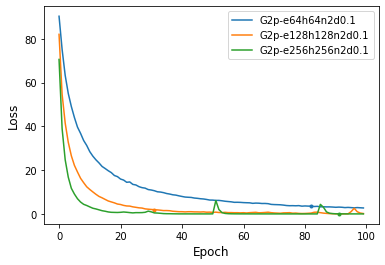

In [165]:
# import matplotlib.pyplot as plt
# # from importlib import reload
# # plt=reload(plt)


#plt.title('G2P LSTM Train Losses',fontsize=18)
print("Train Losses")
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
print(len(combined_models_losses))
ax = plt.gca()
for (i,j) in zip(range(len(combined_models_losses)), combined_best_epochs):
    print(i)
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(combined_models_losses[i,:,0], combined_models_losses[i,:,1], label=j[0], color=color)
    plt. plot(j[1], combined_models_losses[i,j[1],1],linewidth=2, marker ='.', color=color)
plt.locator_params(axis="x", integer=True, tight=True)
plt.legend(loc="upper right")
plt.show()

Eval Loss
3


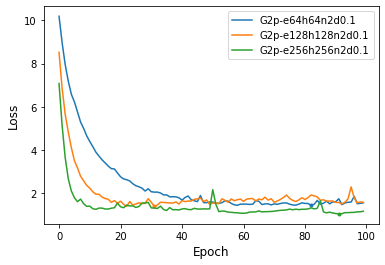

In [166]:
# import matplotlib.pyplot as plt
# # from importlib import reload
# # plt=reload(plt)


#plt.title('G2P LSTM Validation Losses',fontsize=18)
print("Eval Loss")
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)
print(len(combined_models_losses))
ax = plt.gca()
for (i,j) in zip(range(len(combined_models_losses)), combined_best_epochs):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(combined_models_losses[i,:,0], combined_models_losses[i,:,2], label=j[0], color=color)
    plt. plot(j[1], combined_models_losses[i,j[1],2],linewidth=2, marker ='.', color=color)
plt.locator_params(axis="x", integer=True, tight=True)
plt.legend(loc="upper right")
plt.show()

Accuracy
3


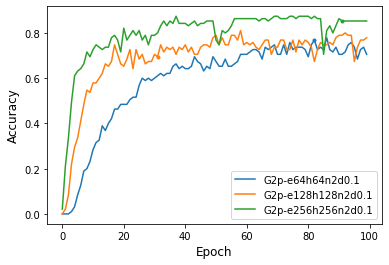

In [164]:
# plt.plot(combined_losses[:,0], combined_losses[:,3], label="acc")
# plt.title('G2P LSTM Accuracy',fontsize=18)
# plt.xlabel('Epoch',fontsize=14)
# plt.ylabel('Accuracy',fontsize=14)
# plt.locator_params(axis="both", integer=True, tight=True)
# plt.show()

# # import matplotlib.pyplot as plt
# # # from importlib import reload
# # # plt=reload(plt)


#plt.title('G2P LSTM Accuracy',fontsize=18)
print("Accuracy")
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
print(len(combined_models_losses))
ax = plt.gca()
for (i,j) in zip(range(len(combined_models_losses)), combined_best_epochs):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(combined_models_losses[i,:,0], combined_models_losses[i,:,3], label=j[0], color=color)
    plt. plot(j[1], combined_models_losses[i,j[1],3],linewidth=2, marker ='.', color=color)
plt.locator_params(axis="x", integer=True, tight=True)
plt.legend(loc="lower right")
plt.show()

PER


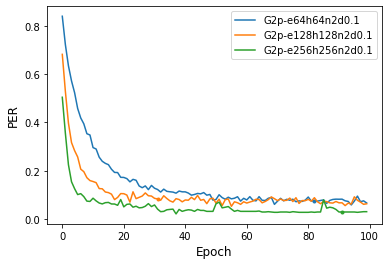

In [168]:
# plt.plot(combined_losses[:,0], combined_losses[:,4], label="PER")
# plt.locator_params(axis="both", integer=True, tight=True)
# plt.title('G2P PER',fontsize=18)
# plt.xlabel('Epoch',fontsize=14)
# plt.ylabel('PER',fontsize=14)
# plt.show()

#plt.title('G2P LSTM PER',fontsize=18)
print("PER")
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('PER',fontsize=12)
ax = plt.gca()
for (i,j) in zip(range(len(combined_models_losses)), combined_best_epochs):
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(combined_models_losses[i,:,0], combined_models_losses[i,:,4], label=j[0], color=color)
    plt. plot(j[1], combined_models_losses[i,j[1],4],linewidth=2, marker ='.', color=color)
plt.locator_params(axis="x", integer=True, tight=True)
plt.legend(loc="upper right")
plt.show()

Incorrect words
3
0
1
2


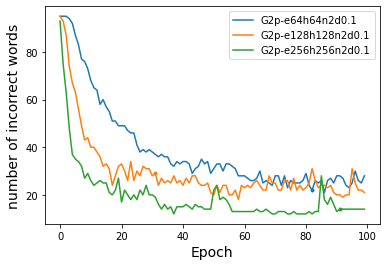

In [154]:
# plt.title('G2P LSTM incorrect words',fontsize=18)
# plt.xlabel('Epoch',fontsize=14)
# plt.ylabel('number of incorrect words',fontsize=14)
# plt.plot(combined_losses[:,0], combined_losses[:,5], label="number of incorrect words")
# plt.locator_params(axis="both", integer=True, tight=True)
# plt.show()

#plt.title('G2P LSTM Incorrect words',fontsize=18)
print("Incorrect words")
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('number of incorrect words',fontsize=14)
print(len(combined_models_losses))
ax = plt.gca()
for (i,j) in zip(range(len(combined_models_losses)), combined_best_epochs):
    print(i)
    color = next(ax._get_lines.prop_cycler)['color']
    plt.plot(combined_models_losses[i,:,0], combined_models_losses[i,:,5], label=j[0], color=color)
    plt. plot(j[1], combined_models_losses[i,j[1],5],linewidth=2, marker ='.', color=color)
plt.locator_params(axis="x", integer=True, tight=True)
plt.legend(loc="upper right")
plt.show()

In [185]:
# reshaping the array from 3D matrice to 2D matrice.
print(combined_models_losses.shape[2])
combined_model_losses_reshape = combined_models_losses.reshape(-2, combined_models_losses.shape[2])
print(combined_model_losses_reshape.shape)
print(combined_model_losses_reshape[-1])
np.savetxt("test.csv", combined_model_losses_reshape)
arr_from_file = np.loadtxt("test1.csv")
print(arr_from_file.shape)
loadedOriginal = arr_from_file.reshape(arr_from_file.shape[0], arr_from_file.shape[1] // combined_models_losses.shape[2], combined_models_losses.shape[2])
loadedOriginal = arr_from_file.reshape(combined_models_losses.shape[0], arr_from_file.shape[0] // combined_models_losses.shape[0], combined_models_losses.shape[2])

print(loadedOriginal.shape)

if(combined_models_losses.all()==loadedOriginal.all()):
    print("1")

6
(300, 6)
[9.90000000e+01 7.68914848e-03 1.15429593e+00 8.52631579e-01
 3.03830911e-02 1.40000000e+01]
(300, 6)
(3, 100, 6)
1


In [156]:
def DataLoading_forG2P(data_file):
    g2p_start = {"a": "a", "b": "b", "c":"k", "d":"d", "e":"E", "f":"f", "g":"x", "h":"h_", "i":"i",
    "j": "j", "k":"k", "l":"l", "m":"m", "n":"n", "o":"O", "p":"p", "q":"k", "r":"r", "s":"s",
    "t":"t", "u":"9y", "v":"f", "w":"v", "x":"z", "y":"@i", "z":"z", "\'":"A:" }
    def sortingWP (d):
        w, p = [], []
        for i in range(0, len(d)):

            #w.append(d[i][0])
            
            #w.append(' '.join(j for j in d[i]))
            w.append(" ".join(d[i]))
            #p.append("2:") 
            if d[i][0] =="a" and d[i][1] =="a": p.append("A:")
            else: p.append(g2p_start[d[i][0]]) # #Starting phone based on starting graph
        return w,p

    with open(data_words_to_G2P) as f:
        data_lines = f.readlines()
    vocab_len = len(data_lines)
    print(vocab_len)

    #Potential to add 'n to train dataset
    
    for i in range(0, len(data_lines)):
        data_lines[i] = data_lines[i].replace("\n","")
    train_data_lines = []
    train_data_lines = data_lines
    train_word, train_phonemes = sortingWP(data_lines)
    
    return train_word, train_phonemes

data_words_to_G2P = "words_to_G2P.txt"
data_set_G, data_set_P = DataLoading_forG2P(data_words_to_G2P)

3431


In [157]:
def generate_pd(model, iter, output_file, device):

    graphemes, phonemes = [],[]
    with torch.no_grad():
        for i,batch in enumerate(iter):
            grapheme_vector, phoneme_vector, decoder_inputs, g_vec_len, p_vec_len = batch
            grapheme_vector = grapheme_vector.to(device)
            phoneme_vector = phoneme_vector.to(device)
            decoder_inputs = phoneme_vector.to(device)
            #print("1")

            phoneme_pred, phoneme_pred_sequence = model(grapheme_vector, g_vec_len,p_vec_len, decoder_inputs, phoneme_vector, False)

            #print("2")
            for j,k in zip(grapheme_vector,phoneme_pred_sequence):
                graphemes.append(data_decoder(j.cpu().numpy().tolist(),1))
                phonemes.append(data_decoder(k.cpu().numpy().tolist(),0))
     
    #print(decoder_inputs) 
    pd = list(zip(graphemes, phonemes))
    

    with open(output_file, 'w') as file:
        for i in range(0, len(pd)):
            word = "".join(str(word) for word in graphemes[i])
            phones =  " ".join(str(p) for p in phonemes[i])
            new_line = word + " " + phones
            file.write('%s \n' %new_line)
    #print(phonemes)
    file.close() 

    

In [158]:
print(cfg.phonemes)

['<pad>', '<s>', '</s>', '2:', '9', '9y', '@', '@i', '@u', 'A:', 'E', 'N', 'O', 'Of', 'S', 'Z', 'a', 'b', 'd', 'e', 'f', 'g', 'h_', 'i', 'i@', 'j', 'k', 'l', 'm', 'n', 'p', 'r', 's', 't', 'u', 'u@', 'v', 'w', 'x', 'y', 'z', '{']


In [159]:
def init_model():
    encoder = Encoder(cfg.embed_dim, cfg.hidden_dim, cfg.g_vocab_size, cfg.n_layers, cfg.dropout)
    decoder = Decoder(cfg.embed_dim, cfg.hidden_dim, cfg.g_vocab_size, cfg.n_layers, cfg.dropout)

    model = G2PModel(encoder, decoder, cfg.device)
    model_params = "best_models/G2pLSTM-e64h128n2.pt"
    model_paramsb = "G2pLSTM-e64h128n2train.pt"
    #model_paramsc = "models/G2pLSTM-e256h256n2trainwitheval.pt"
    #model.load_state_dict(torch.load(model_paramsc))
    print(torch.cuda.is_available())

startnload_new_model = 1
if startnload_new_model: init_model()

True


In [160]:
data_words_to_G2P = "words_to_G2P.txt"
pd_file = "pd_for_data.txt"
data_set_G, data_set_P = DataLoading_forG2P(data_words_to_G2P)
dataset_to_g2p = G2PData(data_set_G, data_set_P)
dataset_to_g2p_iter =  data.DataLoader(dataset_to_g2p,batch_size=cfg.batch_size, shuffle=False, collate_fn=padding_data)
generate_pd(model, dataset_to_g2p_iter, pd_file, cfg.device)

3431


Created with assistance from tutorials and adapted from Sources:
1. https://github.com/Kyubyong/g2p - used for base notebook layout and initial introduction into structure of a G2P model - had no mention of teacherforcing
https://github.com/Kyubyong/nlp_made_easy/blob/master/PyTorch%20seq2seq%20template%20based%20on%20the%20g2p%20task.ipynb
2. https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e#58f2 - assistance in understanding various concepts and functions in [1]
2. https://github.com/bentrevett/pytorch-seq2seq
3. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

4. Further assistance on DataLoader and BucketIterator from: https://colab.research.google.com/github/gmihaila/ml_things/blob/master/notebooks/pytorch/pytorchtext_bucketiterator.ipynb#scrollTo=ChQWVc4IUUPb
